<h1> PyTorch Classification with MLP </h1>
Lets see how we can train our first neural network using the Pytorch funcunalities we have previously seen! In this notebook we will be training a Multilayer Perceptron (MLP) with the MNIST dataset. We will see how to use Pytorch inbuilt datasets, how to construct a MLP using the Pytorch nn.module class and how to construct a training and testing loop to perform stochastic gradient descent (SGD).

<img src="../data/MNIST.gif" width="700" align="center">

Animation of MNIST digits and a MLP's activations changing via learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

<h2> Classification </h2>
In this Notebook we are performing "classification", that is we want our model to predict what group a given input belongs to after being trained with a large number of examples. In our case we are using MNIST, a data-set of small black and white hand written digits. We want our model to predict what digit (0-9) is in the image!

[Classification Explained](https://www.datacamp.com/blog/classification-machine-learning)

<h2> Download the MNIST Train and Test set </h2>
The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing in the field of machine learning, it consists of 60,000 training images and 10,000 testing images as well as the corresponding digit class (0-9) (it has moved out of fashion these days because it is "too easy" to learn though it is still used at times as a "proof of concept").  <br>
Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models. We will look more closely at using Pytorch datasets in a later lab.

[Pytorch Datasets](https://pytorch.org/vision/stable/datasets.html)

In [3]:
# Size of our mini-batches
batch_size = 256 #This is where we set how many data we pass through the model at once
data_set_root = "../../datasets"

# Create a train and test dataset using the Pytorch MNIST dataloader class
# NOTE: IF YOU DO NOT HAVE THE LATEST VERSION OF torchvision YOU WILL NEED TO DOWNLOAD THE MNIST DATASET
# FIRST AS THE LINK THE OLD PYTORCH MNIST DATASET HAS DOES NOT WORK! 
# SEE BELOW BLOCK OF CODE!

train = MNIST(data_set_root, train=True,  download=True, transform=transforms.ToTensor()) #Transform is where augmentations exist
test  = MNIST(data_set_root, train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False) 
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=False)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file, 
# you will rarely need more than 4 #Number of workers is essentially how many threads we run to load the data
# NOTE!!! ON WINDOWS THERE CAN BE ISSUES WITH HAVING MORE THAN 0 WORKERS!! IF YOUR TRAINING LOOP STALLS AND DOES
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if you are training with a GPU!!!! If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

In [ ]:
## IF YOU ARE USING AN OLD VERSION OF PYTORCH
# from torchvision.datasets.utils import download_and_extract_archive
# import os

# url_base = 'https://ossci-datasets.s3.amazonaws.com/mnist/'

# resources = [
#     ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
#     ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
#     ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
#     ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")]


# def download():
#     os.makedirs("./data/MNIST/raw", exist_ok=True)

#     # download files
#     for filename, md5 in resources:
#         url = "{}{}".format(url_base, filename)
#         print("Downloading {}".format(url))
        
#         download_and_extract_archive(
#             url, download_root="./data/MNIST/raw",
#             filename=filename,
#             md5=md5
#         )

        
# download()

In [4]:
# Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') #This is how we set which device we use
print(torch.cuda.is_available())

True


<h3> Visualise a few training samples </h3>
Lets visualise that mini-batches that the dataloader gives us

In [6]:
# We can create an itterater using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape) #The input is a 256x1x28x28 where 28x28 are the images, 1 is for 1 channel
print("The target output data shape is :\n", labels.shape) #The labels are 0-9

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


We can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, the first dimension (d0) is known as the "batch dimension" (B) the other three are the image dimensions (CxHxW). We can this of this 4D Tensor as a stack of 256, 1 channel, 28x28 images.<br>
The image labels are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

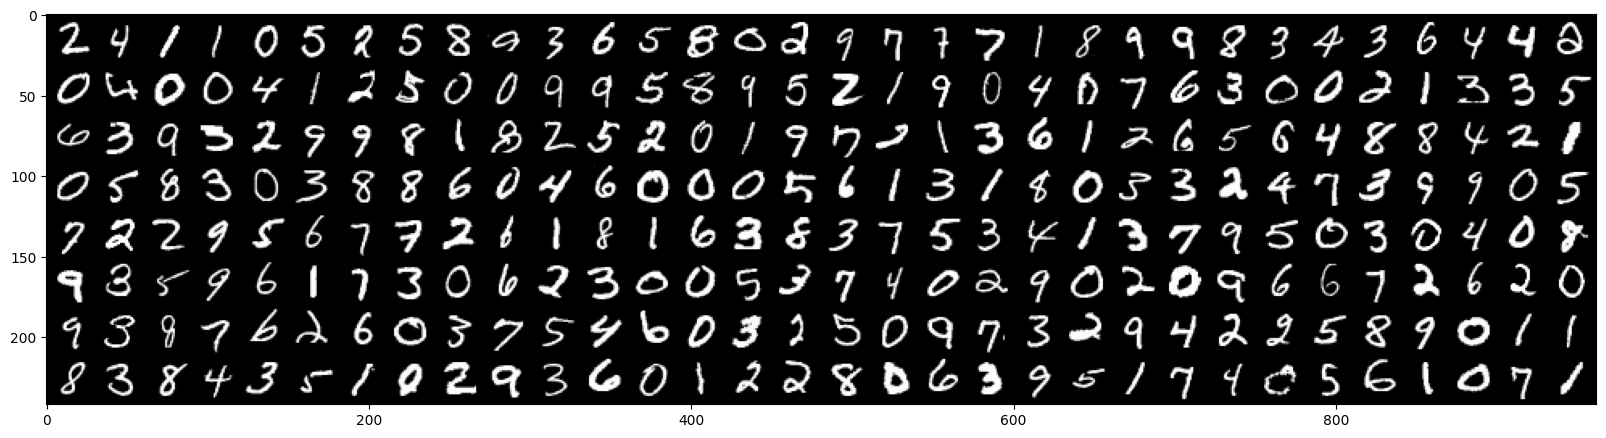

In [7]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images, 32)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [9]:
# Lets create a simple MLP network similar to the sine wave approximator
class Simple_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Simple_MLP, self).__init__()
        # We will use 4 linear layers
        # The input to the model is 784 (28x28 - the image size)
        # and the should be num_classes outputs
        
        # TO DO-  hidded layer size 512
        self.linear1=nn.Linear(784,512)
        # TO DO-  hidded layer size 256
        self.linear2=nn.Linear(512,256)
        # TO DO-  hidded layer size 128
        self.linear3=nn.Linear(256,128)
        # TO DO-  output layer size num_classes
        self.linear4=nn.Linear(128,num_classes)

    def forward(self, x):
        
        # The data we pass the model is a batch of single channel images
        # with shape BSx1x28x28 we need to flatten it to BSx784
        # To use it in a linear layer
        x = x.view(x.shape[0], -1) #We can reshape it with .view (this is the same as .reshape), -1 is "don't care"
        
        # We will use a relu activation function for this network! (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
        
        # These two things are the same for MOST purposes!
        # TO DO, layer and then activation function
        x=F.relu(self.linear1(x))   #ReLu is a piecwise nonlinear activation function
        x=F.relu(self.linear2(x))   #tanh and sigmoid are linear around 0
        x=F.relu(self.linear3(x))   #ReLu we want the values to be around 0 because that's where the nonlinearity is
        x=self.linear4(x) #Final output doesn't have an activation function
        # TO DO, layer and then activation function
        # TO DO, layer and then activation function
        # TO DO, add layer
        return x # TO DO

<h3> Create the model and define the Loss and Optimizer</h3>
Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using Cross Entropy Loss 

[torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

[Killer Combo: Softmax and Cross Entropy by Paolo Perrotta
](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba)

Just like in the sine wave approximation, experiment with different optimizers and hyperparameters 

In [14]:
# Create our model
model = Simple_MLP(10).to(device) # TO DO create a model with 10 classes => (device) is putting it onto the GPU
#Create our loss function
criterion = nn.CrossEntropyLoss() # TO DO add the Cross Entropy loss Function => use cross-entropy for classification
#Probabilities need to be between 0->1 and all our categories need to sum up to 1. So our softmax does this, which is implemented by CrossEntropyLoss()
#Define our loss funcition and optimizer
lr = 1e-3# TO DO
optimizer = optim.Adam(model.parameters(),lr=lr)# TO DO
# Number of Epochs
n_epochs = 20# TO DO

# We can print out our model structure
print(model)
# Note: this is only the order in which the layers were defined NOT the path of the forward pass!

Simple_MLP(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
x=torch.randn(8,10)*10
x.exp() #This makes all our values positive
x.exp()/x.exp().sum(dim=1,keepdim=True) #We keep the second dimension (10) the same, we have a bunch of probabilities between 0-1 and they all sum to 1

tensor([[8.3882e-02, 6.9863e-07, 7.7000e-05, 3.2431e-03, 1.5482e-05, 1.6620e-12,
         8.7322e-01, 1.2639e-15, 1.5429e-07, 3.9560e-02],
        [1.3607e-12, 4.9028e-15, 7.4084e-01, 4.5534e-10, 2.8642e-13, 1.5813e-01,
         2.9517e-17, 1.3696e-04, 1.0090e-01, 1.9132e-10],
        [5.4671e-02, 5.2708e-03, 2.5877e-06, 1.9084e-07, 2.0845e-03, 9.3579e-01,
         2.8321e-09, 2.1780e-03, 8.9568e-11, 3.3218e-07],
        [5.3115e-02, 4.2229e-09, 5.3783e-06, 1.7339e-02, 7.4292e-01, 5.6095e-15,
         2.4995e-06, 9.8248e-14, 1.8662e-01, 7.6797e-11],
        [7.3157e-15, 5.1226e-09, 1.9370e-08, 3.0225e-07, 3.2449e-03, 3.1203e-01,
         2.2315e-03, 2.5887e-04, 4.6753e-01, 2.1470e-01],
        [6.4546e-01, 5.0910e-09, 2.5831e-04, 8.2953e-03, 1.3737e-03, 3.4453e-01,
         2.6503e-07, 2.6815e-07, 6.2797e-05, 2.0313e-05],
        [9.9947e-01, 1.2704e-09, 1.1700e-16, 9.0143e-05, 1.7898e-06, 1.7634e-08,
         7.5598e-07, 3.6253e-04, 7.9019e-05, 5.9702e-07],
        [1.2972e-06, 3.3751

<h3> Create a function that will train the network for one epoch </h3>

In [15]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger): #Essentially we create a single function to run the training on a single epoch
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):   #desc = escription, leave means it won't make the bar dissapear
        
        # Forward pass of model
        outputs = model(data.to(device))# TO DO  (we cast it to the GPU)=> any time we do forward pass of model (which is on a model) we need to add the data on the same device
        # Calculate loss
        loss = criterion(outputs,target.to(device))# TO DO (we need the loss on the same device because model/data is on the GPU)
        
        # Zero gradients
        # TO DO
        optimizer.zero_grad()
        
        # Backprop loss
        # TO DO
        loss.backward()
        
        # Optimization Step
        # TO DO
        optimizer.step()
        
        loss_logger.append(loss.item())

    return model, optimizer, loss_logger

<h3> Create a function that will evaluate our network's performance on the test set </h3>

In [16]:
def test_model(model, test_loader, criterion, loss_logger):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):   
            
            # Forward pass of model
            outputs = model(data.to(device))# TO DO           
            
            # Calculate the accuracy of the model
            # You'll need to accumulate the accuracy over multiple steps

            
            # TO DO
            # Number of correctly predicted outputs
            _,predictions=torch.max(outputs,1) #Essentially, index of max output 
            correct_predictions += (predictions==target.to(device)).sum().item() #Where does the max output prediction index equal the label
            # Total number of predictions made
            total_predictions += target.shape[0]# TO DO
            
            # Calculate the loss
            loss = criterion(outputs,target.to(device))# TO DO
            loss_logger.append(loss.item())
            
        acc = (correct_predictions/total_predictions) * 100.0
        return loss_logger, acc

## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [18]:
# Create empty lists for the train/test losses and the test accuracy
train_loss = []
test_loss  = []
test_acc   = []

In [19]:
for i in trange(n_epochs, desc="Epoch", leave=False):
    # Call the training function to perform an epoch of training
    model, optimizer, train_loss = train_epoch(model,train_loader,criterion,optimizer,train_loss)# TO DO
    
    # Call the testing function to work out the test loss and accuracy!
    test_loss, acc = test_model(model,test_loader,criterion,test_loss)# TO DO
    test_acc.append(acc)

print("Final Accuracy: %.2f%%" % acc)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Final Accuracy: 98.17%


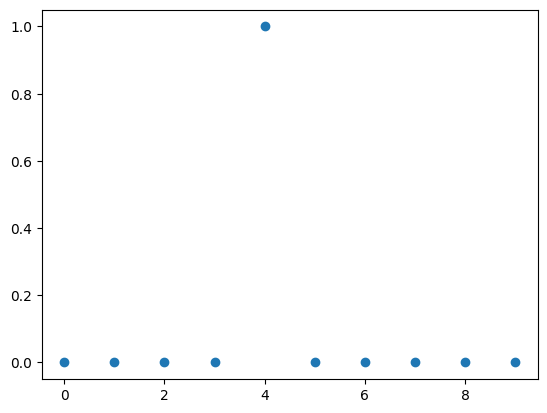

In [34]:
x=model(images.to(device))
plt.scatter(np.arange(10),F.softmax(x,1)[1].detach().cpu().numpy())


## Visualize Training Data

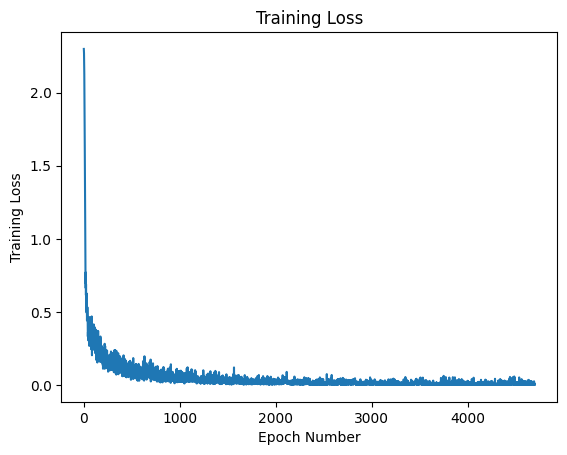

In [21]:
# Plot the Training and Test losses
# TO DO
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.plot(train_loss)

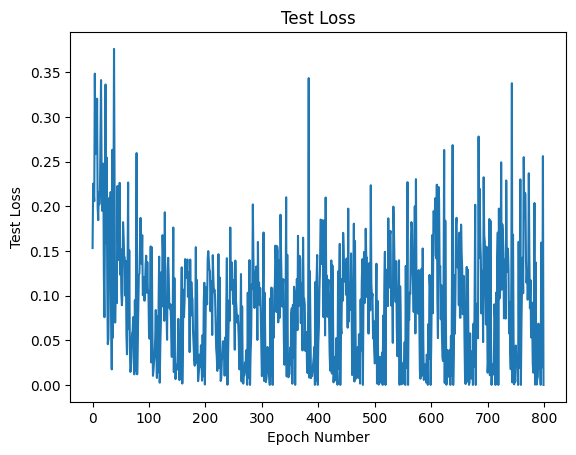

In [22]:
plt.title("Test Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Test Loss")
plt.plot(test_loss)

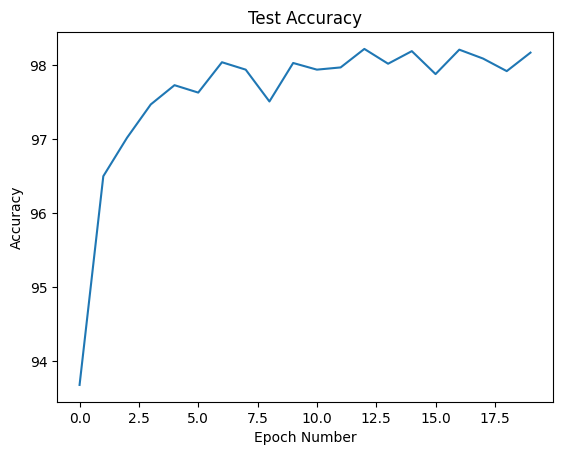

In [23]:
# Plot the Test Accuracy
# TO DO
plt.title("Test Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.plot(test_acc)